<a href="https://colab.research.google.com/github/gr-grey/genomic-courses/blob/main/project1_naive_exact_match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Exact Match

Find patterns that matches the given "lambda virus" genome sequence
https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/lambda_virus.fa

Q1. How many times does AGGT or its reverse complement ACCT occur in the lambda virus genome? E.g. if AGGT occurs 10 times and ACCT occurs 12 times, you should report 22.

Q2. How many times does TTAA or its reverse complement occur in the lambda virus genome? Hint: TTAA and its reverse complement are equal, so remember not to double count.

Q3. What is the offset of the leftmost occurrence of ACTAAGT or its reverse complement in the Lambda virus genome? E.g. if the leftmost occurrence of ACTAAGT is at offset 40 (0-based) and the leftmost occurrence of its reverse complement ACTTAGT is at offset 29, then report 29.

Q4. What is the offset of the leftmost occurrence of AGTCGA or its reverse complement in the Lambda virus genome?

## Solution

We need to read the FastA file and store the entire genome as a string.

Write a naive exact match function that returns matching location of the patern p, given the sequence s.

To consider also reverse complements, we need a function that turns a sequence string to its reverse complements, then get the reverse complements of both p and s.
If s does not equal to its reverse completment, we'll check the reverse complement matching and append the results.

In [ ]:
# download genome file
!wget https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/lambda_virus.fa

--2023-04-07 19:32:02--  https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/lambda_virus.fa
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 13.249.90.54, 13.249.90.71, 13.249.90.4, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|13.249.90.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49270 (48K) [application/octet-stream]
Saving to: ‘lambda_virus.fa.2’

lambda_virus.fa.2   100%[===================>]  48.12K  --.-KB/s    in 0.01s   

2023-04-07 19:32:02 (4.00 MB/s) - ‘lambda_virus.fa.2’ saved [49270/49270]



In [ ]:
# read FastA file and return the whole genome as a string
def readGenome(fastAfile): 
    genome = ''
    with open(fastAfile, 'r') as f:
        for line in f:
            if not line[0] == '>': # the line contains string
                # strip the endline char, add to genome
                genome += line.rstrip() 
    return genome


genome = readGenome('lambda_virus.fa')

In [ ]:
def naive(p,s): # exact match of p in s
    occurrences = []
    for i in range(len(s) - len(p) + 1):
        match = True
        for j in range(len(p)):
            if not p[j] == s[i+j]: # find mismatch
                match = False
                break
        if match:
            occurrences.append(i)
    return occurrences
    
def reverseComplement(s):
    complement = {'A':'T', 'G':'C', 'C':'G', 'T':'A', 'N':'N'}
    rc_seq = ''
    for base in s:
        rc = complement[base]
        rc_seq = rc + rc_seq # prepend so the compelment is reversed
    return rc_seq

# navie with checking of reverse complement
def naive_rc(p, s): 
    occurrences = naive(p, s)
    p_rc = reverseComplement(p)
    # skip checking if p equals to its reverse complement
    if not p == p_rc:
        occurrences.extend(naive(p_rc, s))
    return occurrences 

In [ ]:
# Q1
print(len(naive_rc('AGGT', genome)))
# Q2
print(len(naive_rc('TTAA', genome)))
# Q3
print(min(naive_rc('ACTAAGT', genome)))
# Q4
print(min(naive_rc('AGTCGA', genome)))

306
195
26028
450


Q5. Make a new version of the naive function called naive_2mm that allows up to 2 mismatches per occurrence. Unlike for the previous questions, do not consider the reverse complement here. How many times does TTCAAGCC occur in the Lambda virus genome when allowing up to 2 mismatches?

Q6. What is the offset of the leftmost occurrence of AGGAGGTT in the Lambda virus genome when allowing up to 2 mismatches?

## Solution

To allow mismathces, we'll use a counter variable to record number of mismatches.
When mismatches happen, instead of immediately break out of the comparing loop, we check if the number of mismatches has exceeded the threshold, and only break when it does (in this case >2). 

In [ ]:
# naive matching with maximum of m errors
def naive_mm(p,s,m): 
    occurrences = []
    for i in range(len(s) - len(p) + 1):
        match = True
        mistakes = 0
        for j in range(len(p)):
            if not p[j] == s[i+j]: # find mismatch
                mistakes += 1
                if mistakes > m: # exceed error limits
                    match = False
                    break
        if match:
            occurrences.append(i)
    return occurrences

In [ ]:
# Q5
print(len(naive_mm('TTCAAGCC', genome, 2)))
# Q6
print(min(naive_mm('AGGAGGTT', genome, 2)))

191
49


## Q7 Find the abnormal sequencing cycle

Download and parse the provided FASTQ file containing real DNA sequencing reads derived from a human:

https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq


This dataset has something wrong with it; one of the sequencing cycles is poor quality.

Report which sequencing cycle has the problem.  Remember that a sequencing cycle corresponds to a particular offset in all the reads. For example, if the leftmost read position seems to have a problem consistently across reads, report 0. If the fourth position from the left has the problem, report 3. Do whatever analysis you think is needed to identify the bad cycle. It might help to review the "Analyzing reads by position" video.

## Solution

We need to extract quality scores for each read from the FastQ file, store them in a 2d array.

Then convert them into integers.

For each position (each column), we'll calculate the mean score and plot the result to find out which site looks fishy.

In [ ]:
def readFastQ(filename):
    sequences, qualities = [], []
    with open(filename, 'r') as f:
        while True:
            f.readline() # first line is name, ignore
            seq = f.readline().rstrip() # second line is sequence
            f.readline() # third line is placeholder, ignore
            qual = f.readline().rstrip() # fourth line is qualities
            if len(seq) == 0: # reach the end of file
                break
            sequences.append(seq)
            qualities.append(qual)
    return sequences, qualities

def phred33toQ(qchar):
    return ord(qchar) - 33

In [ ]:
# Download file and extract quality as 2D array
!wget https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq

seqs, quals = readFastQ('ERR037900_1.first1000.fastq')

--2023-04-07 19:43:27--  https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 13.249.90.71, 13.249.90.4, 13.249.90.54, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|13.249.90.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241626 (236K) [application/octet-stream]
Saving to: ‘ERR037900_1.first1000.fastq’

ERR037900_1.first10 100%[===================>] 235.96K  --.-KB/s    in 0.03s   

2023-04-07 19:43:27 (7.71 MB/s) - ‘ERR037900_1.first1000.fastq’ saved [241626/241626]



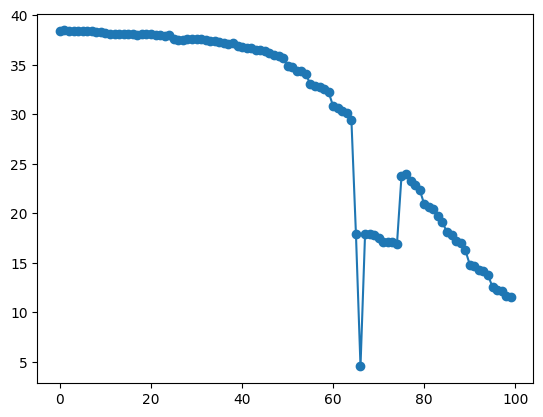

In [ ]:
# convert quals into 2d array of scores 
scores = []

for qual in quals: # loop through each read
  phredscores = []
  for qchar in qual: # loop through each base
    phredscores.append(phred33toQ(qchar))
  scores.append(phredscores) 

# transpose the matrix so each row corresponds to one read position
import numpy as np

scores = np.transpose(scores)
# calculate mean score for each row (each position)
avescores = np.mean(scores, axis =1)

# plot average score to find weird site
import matplotlib.pyplot as plt 

plt.plot(np.arange(0,100), avescores, marker='o')

plt.show()

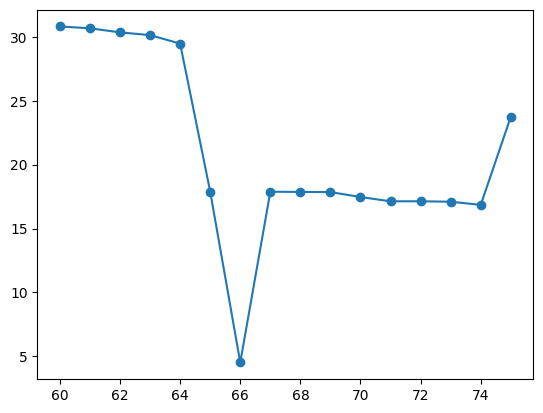

In [ ]:
# We can see the big dip of quality at sites between 60 - 75
# Zoom in to see which site it is

plt.plot(np.arange(60,76), avescores[60:76], marker='o')

plt.show()

We can find out site 66 is problematic.

We can double check by pulling the scores at site 66, or plotting the same region in box plot.

In [ ]:
print(scores[66])

[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 18  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 34  2  2  2
  2 40  2  2  2  2  2  2 38  2  2  2  2  2  2  2 23  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2 35 34  2  2  2  2  2  2  2  2 18
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 34  2  2  2  2
  2  2  2  2  2 25  2  2  2  2 20  2  2  2  2  2 31  2  2  2  2  2 38  2
  2  2  2  2  2  2  2  2  2  2 37  2  2  2  2  2  2  2  2  2  2  2  2  2
  2 36  2  2  2  2  2  2  2  2  2  2  2 30  2  2  2  2  2 39  2 35  2  2
  2  2  2  2  2  2  2  2  2  2  2 39  2 30  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2 32  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2 38  2 30  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2

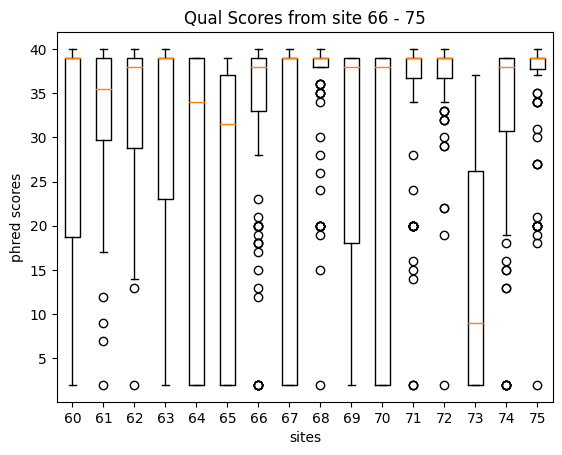

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# create a boxplot of the data
fig, ax = plt.subplots()
ax.boxplot(scores[:, 60 : 76])

ax.set_xticklabels(np.arange(60,76))
# add labels and titles
ax.set_xlabel('sites')
ax.set_ylabel('phred scores')
ax.set_title('Qual Scores from site 66 - 75')

# display the plot
plt.show()

We can see that indeed there are a lot of low scores (2) and a lot of low outliers at site 66.